TL;DR

Data: Top 100 movies (http://www.imdb.com/list/ls055592025/) with title, genre, and synopsis (IMDB and Wiki)
Goal: Put 100 movies into 5 clusters based on text mining their synopses

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

Read movie titles, 100 movies but somehow the last one is empty string

In [2]:
# so that you need to use print()
from __future__ import print_function
titles = open('data/title_list.txt').read().split('\n')

In [3]:
len(titles)

101

In [4]:
titles[:10]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic']

In [5]:
titles = titles[:100]

Read Genres information

In [6]:
genres = open('data/genres_list.txt').read().split('\n')
genres = genres[:100]

In [7]:
genres[0]

"[u' Crime', u' Drama']"

Read in the synopses from wiki

In [8]:
synopses_wiki = open('data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')

In [9]:
len(synopses_wiki)

101

In [10]:
synopses_wiki = synopses_wiki[:100]

In [11]:
synopses_wiki[0]

' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson 

strips html formatting and converts to unicode

In [12]:
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

In [13]:
synopses_wiki[0]

u' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

Read synopses information from imdb, which might be different from wiki. Also cleaned as above.

In [14]:
synopses_imdb = open('data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_imdb.append(text)
synopses_imdb = synopses_clean_imdb

In [15]:
synopses_imdb[0]

u'\n\nIn late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone\'s daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter\'s wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who\'d avoided most contact with the Don due to Corleone\'s nefarious business dealings. The Don\'s wife is godmother to Bonasera\'s shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. The Don agrees to have his

Combine synopses from wiki and imdb

In [16]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [17]:
synopses[0]

u' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

In [18]:
print(str(len(titles)) + ' titles')
print(str(len(genres)) + ' genres')
print(str(len(synopses)) + ' synopses')

100 titles
100 genres
100 synopses


In [19]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
# the movies in the list are already ranked from 1 to 100
ranks = []
for i in range(1, len(titles)+1):
    ranks.append(i)

In [20]:
# load nltk's English stopwords as variable called 'stopwords'
# use nltk.download() to install the corpus first
# Stop Words are words which do not contain important significance to be used in Search Queries
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [21]:
len(stopwords)

179

In [22]:
stopwords

[u'i',
 u'me',
 u'my',
 u'myself',
 u'we',
 u'our',
 u'ours',
 u'ourselves',
 u'you',
 u"you're",
 u"you've",
 u"you'll",
 u"you'd",
 u'your',
 u'yours',
 u'yourself',
 u'yourselves',
 u'he',
 u'him',
 u'his',
 u'himself',
 u'she',
 u"she's",
 u'her',
 u'hers',
 u'herself',
 u'it',
 u"it's",
 u'its',
 u'itself',
 u'they',
 u'them',
 u'their',
 u'theirs',
 u'themselves',
 u'what',
 u'which',
 u'who',
 u'whom',
 u'this',
 u'that',
 u"that'll",
 u'these',
 u'those',
 u'am',
 u'is',
 u'are',
 u'was',
 u'were',
 u'be',
 u'been',
 u'being',
 u'have',
 u'has',
 u'had',
 u'having',
 u'do',
 u'does',
 u'did',
 u'doing',
 u'a',
 u'an',
 u'the',
 u'and',
 u'but',
 u'if',
 u'or',
 u'because',
 u'as',
 u'until',
 u'while',
 u'of',
 u'at',
 u'by',
 u'for',
 u'with',
 u'about',
 u'against',
 u'between',
 u'into',
 u'through',
 u'during',
 u'before',
 u'after',
 u'above',
 u'below',
 u'to',
 u'from',
 u'up',
 u'down',
 u'in',
 u'out',
 u'on',
 u'off',
 u'over',
 u'under',
 u'again',
 u'further',
 u'th

In [23]:
sents = [sent for sent in nltk.sent_tokenize("Today (May 19, 2016) is his only daughter's wedding. Vito Corleone is the Godfather. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception.")]

In [24]:
sents

["Today (May 19, 2016) is his only daughter's wedding.",
 'Vito Corleone is the Godfather.',
 "Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception."]

In [25]:
words = [word for word in nltk.word_tokenize(sents[0])]
words

['Today',
 '(',
 'May',
 '19',
 ',',
 '2016',
 ')',
 'is',
 'his',
 'only',
 'daughter',
 "'s",
 'wedding',
 '.']

In [26]:
# filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
filtered_words = []
for word in words:
        if re.search('[a-zA-Z]', word):
            filtered_words.append(word)
filtered_words

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [27]:
# see how "only" is stemmed to "onli" and "wedding" is stemmed to "wed"
stems = [stemmer.stem(t) for t in filtered_words]
stems

[u'today', u'may', 'is', u'his', u'onli', u'daughter', "'s", u'wed']

In [28]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
# Punkt Sentence Tokenizer, sent means sentence 
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [29]:

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [30]:
words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

[u'today', u'may', 'is', u'his', u'onli', u'daughter', "'s", u'wed']


In [31]:
words_only = tokenize_only("Today (May 19, 2016) is his only daughter's wedding.")
words_only

['today', 'may', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized

In [32]:
# extend vs. append
a = [1, 2]
b = [3, 4]
c = [5, 6]
b.append(a)
c.extend(a)
print(b)
print(c)

[3, 4, [1, 2]]
[5, 6, 1, 2]


In [33]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [34]:
print(len(totalvocab_stemmed))
print(len(totalvocab_tokenized))

312280
312280


In [35]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame.head())

there are 312280 items in vocab_frame
     words
plot  plot
edit  edit
edit  edit
edit  edit
on      on


In [36]:
words_frame = pd.DataFrame({'WORD': words_only}, index = words_stemmed)
print('there are ' + str(words_frame.shape[0]) + ' items in words_frame')
print(words_frame)

there are 8 items in words_frame
              WORD
today        today
may            may
is              is
his            his
onli          only
daughter  daughter
's              's
wed        wedding


Generate TF-IDF matrix (see http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams

In [37]:
# Note that the result of this block takes a while to show
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

# (100, 563) means the matrix has 100 rows and 563 columns
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
len(terms)

CPU times: user 12.1 s, sys: 192 ms, total: 12.3 s
Wall time: 13.1 s
(100, 563)


563

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
# A short example using the sentences above
words_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time words_matrix = words_vectorizer.fit_transform(sents) #fit the vectorizer to synopses

# (2, 18) means the matrix has 2 rows (two sentences) and 18 columns (18 terms)
print(words_matrix.shape)
print(words_matrix)

# this is how we get the 18 terms
analyze = words_vectorizer.build_analyzer()
print(analyze("Today (May 19, 2016) is his only daughter's wedding."))
print(analyze("Vito Corleone is the Godfather."))
print(analyze("Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception."))
all_terms = words_vectorizer.get_feature_names()
print(all_terms)
print(len(all_terms))

# sent 1 and 2, similarity 0, sent 1 and 3 shares "his", sent 2 and 3 shares Vito - try to change Vito's in sent3 to His and see the similary matrix changes
example_similarity = cosine_similarity(words_matrix)
example_similarity

CPU times: user 5.28 ms, sys: 201 µs, total: 5.48 ms
Wall time: 8.28 ms
(3, 58)
  (0, 14)	0.293883860165
  (0, 36)	0.293883860165
  (0, 45)	0.293883860165
  (0, 1)	0.293883860165
  (0, 13)	0.293883860165
  (0, 35)	0.293883860165
  (0, 44)	0.293883860165
  (0, 54)	0.293883860165
  (0, 0)	0.223506250645
  (0, 12)	0.293883860165
  (0, 34)	0.293883860165
  (0, 43)	0.293883860165
  (1, 53)	0.423394483412
  (1, 8)	0.423394483412
  (1, 52)	0.423394483412
  (1, 21)	0.423394483412
  (1, 7)	0.423394483412
  (1, 49)	0.322002417819
  (2, 17)	0.155875983098
  (2, 6)	0.155875983098
  (2, 27)	0.155875983098
  (2, 20)	0.155875983098
  (2, 24)	0.155875983098
  (2, 48)	0.155875983098
  (2, 11)	0.155875983098
  :	:
  (2, 19)	0.155875983098
  (2, 23)	0.155875983098
  (2, 47)	0.155875983098
  (2, 10)	0.155875983098
  (2, 29)	0.155875983098
  (2, 32)	0.155875983098
  (2, 39)	0.155875983098
  (2, 56)	0.155875983098
  (2, 2)	0.155875983098
  (2, 50)	0.155875983098
  (2, 37)	0.155875983098
  (2, 41)	0.15587598

array([[ 1.        ,  0.        ,  0.02649615],
       [ 0.        ,  1.        ,  0.03817265],
       [ 0.02649615,  0.03817265,  1.        ]])

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima - how to decide that the algorithm converged???

In [39]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 75.7 ms, sys: 2.24 ms, total: 77.9 ms
Wall time: 82.3 ms


I use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [40]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
# clusters show which cluster (0-4) each of the 100 synoposes belongs to
print(len(clusters))
print(clusters)

100
[2, 0, 0, 3, 0, 1, 2, 2, 1, 1, 0, 3, 1, 3, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 3, 4, 1, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 4, 1, 4, 2, 1, 2, 2, 0, 1, 2, 3, 0, 0, 3, 0, 0, 0, 2, 3, 1, 0, 0, 3, 2, 4, 1, 4, 3, 2, 1, 3, 2, 2, 2, 4, 1, 2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 0, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 2]


Here, I create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre [rank and genre were scraped from IMDB].
I convert this dictionary to a Pandas DataFrame for easy access. I'm a huge fan of Pandas and recommend taking a look at some of its awesome functionality which I'll use below, but not describe in a ton of detail.

In [41]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

print(frame) # here the ranking is still 0 to 99

frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)


    rank                                              title  cluster  \
2      1                                      The Godfather        2   
0      2                           The Shawshank Redemption        0   
0      3                                   Schindler's List        0   
3      4                                        Raging Bull        3   
0      5                                         Casablanca        0   
1      6                    One Flew Over the Cuckoo's Nest        1   
2      7                                 Gone with the Wind        2   
2      8                                       Citizen Kane        2   
1      9                                   The Wizard of Oz        1   
1     10                                            Titanic        1   
0     11                                 Lawrence of Arabia        0   
3     12                             The Godfather: Part II        3   
1     13                                             Psycho     

1    33
0    27
2    21
3    13
4     6
dtype: int64

In [42]:
grouped = frame['rank'].groupby(frame['cluster']) # groupby cluster for aggregation purposes

grouped.mean() # average rank (1 to 100) per cluster

cluster
0    45.111111
1    53.909091
2    51.476190
3    49.923077
4    53.833333
Name: rank, dtype: float64

Note that clusters 4 and 0 have the lowest rank, which indicates that they, on average, contain films that were ranked as "better" on the top 100 list.
Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [43]:
from __future__ import print_function

print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:
Cluster 0 words: killed, soldiers, army, command, orders, men,

Cluster 0 titles: The Shawshank Redemption, Schindler's List, Casablanca, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, Patton, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, Platoon, High Noon, Dances with Wolves, The Deer Hunter, All Quiet on the Western Front, The Grapes of Wrath, Shane, The Green Mile, Stagecoach, Mutiny on the Bounty,

Cluster 1 words: car, police, father, n't, house, says,

Cluster 1 titles: One Flew Over the Cuckoo's Nest, The Wizard of Oz, Titanic, Psycho, Vertigo, On the Waterfront, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Some Like It Hot, 12 Angry Men,

Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). cosine similarity 1 means the same document, 0 means totally different ones. dist is defined as 1 - the cosine similarity of each document.  Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [44]:

similarity_distance = 1 - cosine_similarity(tfidf_matrix)
print(type(similarity_distance))
print(similarity_distance.shape)

<type 'numpy.ndarray'>
(100, 100)


Multidimensional scaling
Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [45]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)

print(pos.shape)
print(pos)

xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))
xs

CPU times: user 259 ms, sys: 28 ms, total: 287 ms
Wall time: 291 ms
(100, 2)
[[ 0.18426392 -0.01169842]
 [ 0.44205428 -0.27868322]
 [-0.03170436 -0.45668598]
 [-0.13229217  0.57451091]
 [-0.25841725 -0.26522602]
 [ 0.05785577  0.25692859]
 [ 0.05839869 -0.04611703]
 [ 0.01187013  0.46248536]
 [-0.43453171 -0.29660614]
 [ 0.60376368 -0.34565548]
 [-0.25091002 -0.57483642]
 [ 0.07160787  0.13140356]
 [-0.22762168  0.06857695]
 [-0.43010128  0.28541414]
 [-0.35281829  0.12701319]
 [-0.05335737  0.12312849]
 [ 0.35479363  0.00829071]
 [ 0.55258281  0.49022359]
 [-0.48428094  0.17299841]
 [ 0.19843471 -0.38928027]
 [-0.021734   -0.04272077]
 [ 0.35007455 -0.33949066]
 [ 0.51777172 -0.25365403]
 [-0.55227595 -0.22475587]
 [-0.0823774  -0.57842927]
 [-0.3416057   0.63448085]
 [ 0.4192022   0.58545205]
 [-0.17104807  0.23239529]
 [ 0.53065154  0.12944971]
 [-0.01629042 -0.63557262]
 [ 0.41546634  0.40696883]
 [ 0.01973405 -0.63603671]
 [ 0.4334202   0.14567842]
 [ 0.24384331 -0.50412021]
 [ 0.

array([ 0.18426392,  0.44205428, -0.03170436, -0.13229217, -0.25841725,
        0.05785577,  0.05839869,  0.01187013, -0.43453171,  0.60376368,
       -0.25091002,  0.07160787, -0.22762168, -0.43010128, -0.35281829,
       -0.05335737,  0.35479363,  0.55258281, -0.48428094,  0.19843471,
       -0.021734  ,  0.35007455,  0.51777172, -0.55227595, -0.0823774 ,
       -0.3416057 ,  0.4192022 , -0.17104807,  0.53065154, -0.01629042,
        0.41546634,  0.01973405,  0.4334202 ,  0.24384331,  0.08014907,
       -0.15255046, -0.02008183, -0.15297793, -0.2275835 , -0.28462978,
        0.3432853 ,  0.66985503,  0.21420712, -0.20373328,  0.3181654 ,
       -0.19659297,  0.34423528,  0.16075134,  0.12888676,  0.07966542,
        0.49287618, -0.06989475, -0.34784461, -0.36089513, -0.59626379,
       -0.1126573 , -0.66226088,  0.182711  ,  0.15640009,  0.20867879,
        0.18341909, -0.08782998, -0.18336929, -0.45991541,  0.56562552,
        0.40204401, -0.42083182,  0.66776271, -0.30315864,  0.64

Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).
First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [46]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}


Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

   label                            title         x         y
1      0         The Shawshank Redemption  0.442054 -0.278683
2      0                 Schindler's List -0.031704 -0.456686
3      3                      Raging Bull -0.132292  0.574511
4      0                       Casablanca -0.258417 -0.265226
5      1  One Flew Over the Cuckoo's Nest  0.057856  0.256929
6      2               Gone with the Wind  0.058399 -0.046117
7      2                     Citizen Kane  0.011870  0.462485
8      1                 The Wizard of Oz -0.434532 -0.296606
9      1                          Titanic  0.603764 -0.345655
{0: [1, 2, 4, 10, 19, 24, 29, 31, 33, 34, 35, 36, 37, 38, 48, 52, 53, 55, 56, 57, 61, 62, 78, 79, 80, 88, 89], 1: [5, 8, 9, 12, 14, 15, 18, 20, 21, 22, 23, 27, 28, 39, 42, 45, 49, 60, 66, 70, 76, 81, 83, 84, 85, 86, 90, 91, 93, 94, 95, 97, 98], 2: [0, 6, 7, 16, 17, 32, 40, 44, 46, 47, 50, 58, 64, 69, 72, 73, 74, 77, 82, 87, 99], 3: [3, 11, 13, 25, 30, 51, 54, 59, 63, 68, 71, 92

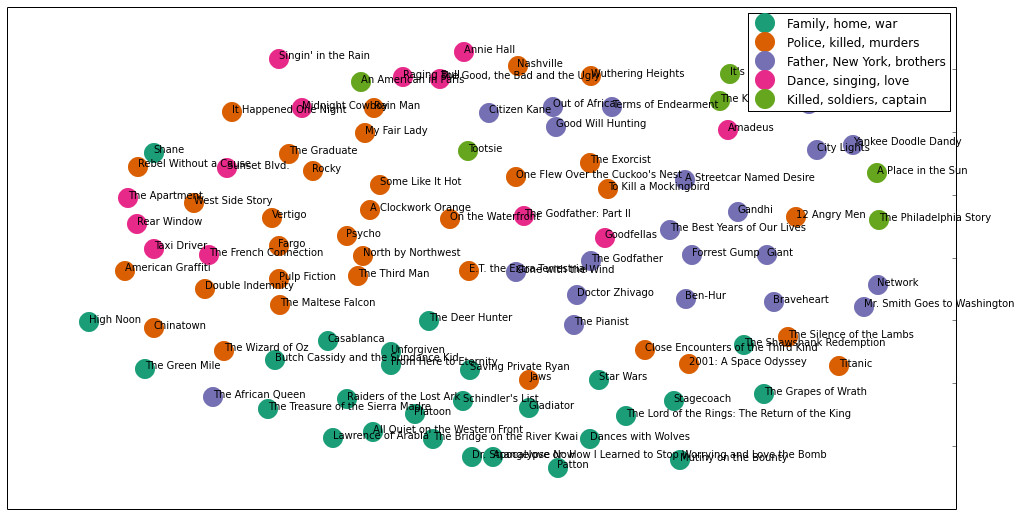

In [47]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

print(df[1:10])
# group by cluster
# this generate {name:group(which is a dataframe)}
groups = df.groupby('label')
print(groups.groups)


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# ms: marker size
for name, group in groups:
    print("*******")
    print("group name " + str(name))
    print(group)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=10)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

Use plotly to generate interactive chart. I have to downgrade matplotlib to 1.3.1 for this chart to work with plotly. see https://github.com/harrywang/plotly/blob/master/README.md for how to setup plotly. After running the following, a browser will open to show the plotly chart.

In [48]:
# import plotly.plotly as py
# plot_url = py.plot_mpl(fig)